### Experiment 3: Conformal prediction for time series forecasting

In this third experiment we move from predicting the quantile of a sequence to an actual application of conformal prediction. Specifically, we consider a time series forecasting task from (Gibbs and Candes, 2021), where the goal is to quantify the uncertainty of a base model that predicts the time varying volatility of a stock. We build this experiment on top of the exact implementation from (Bastani et al., 2022). See Section 4.3.1 of (Bastani et al., 2022) for the setup. https://github.com/ProgBelarus/MultiValidPrediction/blob/main/experiments/Time%20Series%20-%20Stock%20Returns.ipynb

First off, we initialize the experiment as follows. The stock price data is loaded and visualized. 

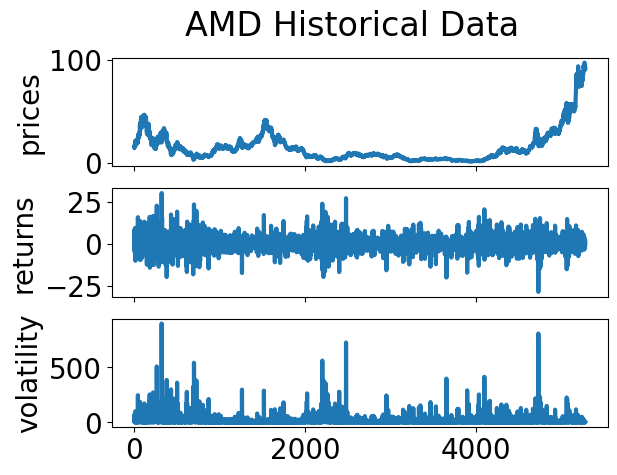

In [1]:
import sys
sys.path.append('./src')
sys.path.append('./Data')

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth': 3})

from Baselines import MultiValidPrediction
from BayesianQuantile import DiscountedBayesian
import utils

dataset_name = 'AMD'

T, prices, returns, volatility = utils.stock_history(dataset_name, ret_scale=100)

queried_confidence = 0.9
delta = 1 - queried_confidence  # targeted miscoverage level, required by the baselines

The base model is a standard sequential prediction method called GARCH. 

In [2]:
scores, predictions = utils.garch_scores(returns, volatility)

The first baseline is the ACI algorithm from (Gibbs and Candes, 2021). Specialized to time series forecasting, it corresponds to predicting a quantile of the observed scores in a fixed-size lookback window, where the quantile level is selected by fixed-learning-rate OGD. We adopt the exact implementation and hyperparameter setting as in (Bastani et al., 2022). 

In [3]:
# Hyperparameters of ACI

ACI_offset = 10
ACI_lookback = 100
ACI_gamma = 0.005

# initialization
ACI_iterate = delta
ACI_thresholds = [0 for i in range(ACI_offset)]
ACI_err_seq = [0 for i in range(ACI_offset)]

for t in range(ACI_offset, T):
    left_ind = max(0, t - ACI_lookback)
    right_ind = t
    recent_scores = scores[left_ind: right_ind]

    if 1 - ACI_iterate > 1:
      threshold = 1
    elif 1 - ACI_iterate < 0:
      threshold = 0
    else:
      threshold = np.quantile(recent_scores, 1 - ACI_iterate)
    err_ind = int(scores[t] > threshold)

    ACI_iterate = ACI_iterate + ACI_gamma * (delta - err_ind)

    # update arrays with data
    ACI_thresholds.append(threshold)
    ACI_err_seq.append(err_ind)

ACI_miscoverage_rate = np.mean(np.array(ACI_err_seq))

The second baseline is MVP from (Bastani et al., 2022), in the marginal setting. 

In [4]:
n_buckets = 40
eta = np.sqrt(np.log(2 * 1 * n_buckets) / T)

myMVP = MultiValidPrediction(delta=delta, n_buckets=n_buckets, eta=eta, normalize_by_counts=False, seed=1)

for t in range(T):
    threshold = myMVP.predict(t)
    myMVP.update(t, threshold, scores[t])

MVP_thresholds, MVP_err_seq = myMVP.coverage_stats()
MVP_miscoverage_rate = np.mean(np.array(MVP_err_seq))

Next we implement our algorithm. The nature of the time series requires using the discounted version of our algorithm. For a fair comparison, the discount factor is chosen such that the effective length of the lookback window is the same as the one used by ACI. That is, there is no extra hyperparameter tuning.

In [5]:
Bayesian_discount = np.sqrt( (ACI_lookback - 1) / ACI_lookback)

myBayesian = DiscountedBayesian(discount=Bayesian_discount, n_bins=n_buckets)

Bayesian_err_seq = []
Bayesian_thresholds = []
for t in range(T):
    threshold = myBayesian.output(queried_confidence)
    myBayesian.update(scores[t])
    err_ind = int(scores[t] > threshold)
    Bayesian_thresholds.append(threshold)
    Bayesian_err_seq.append(err_ind)

Bayesian_miscoverage_rate = np.mean(np.array(Bayesian_err_seq))

Below we print the miscoverage rates, and visualize the predicted threshold sequence of the three algorithms. 

Bayesian miscoverage rate:  0.10145750520537573
ACI miscoverage rate:  0.09937535491198182
MVP miscoverage rate:  0.10713609691463184


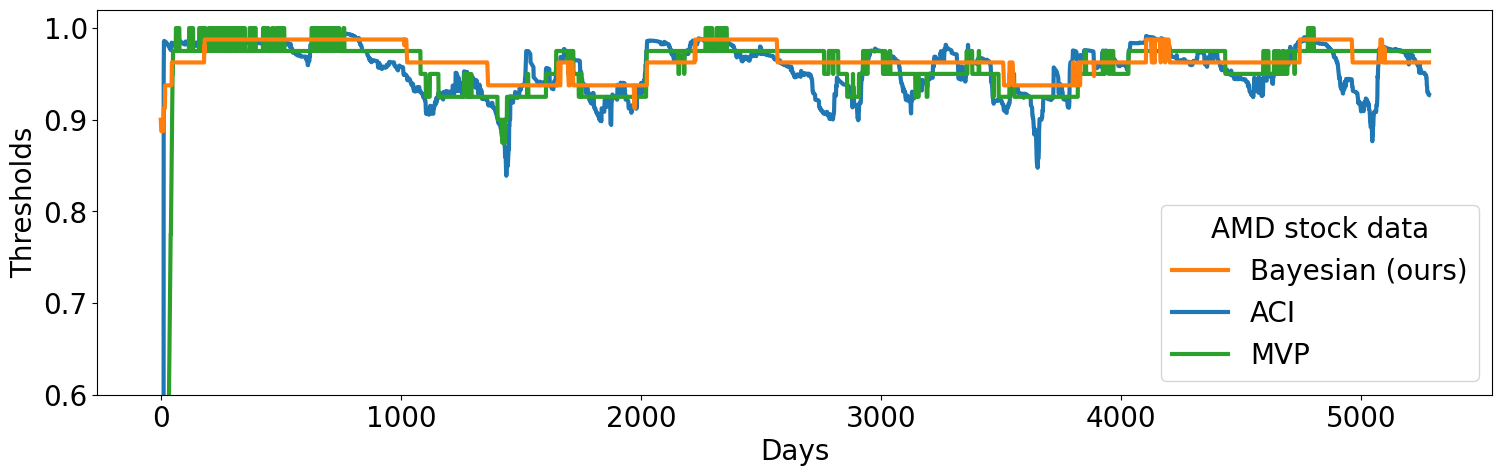

In [6]:
print('Bayesian miscoverage rate: ', Bayesian_miscoverage_rate)
print('ACI miscoverage rate: ', ACI_miscoverage_rate)
print('MVP miscoverage rate: ', MVP_miscoverage_rate)

plt.figure(figsize=(18, 5))
plt.plot(Bayesian_thresholds, label='Bayesian (ours)', color='#ff7f0e', zorder=3)
plt.plot(ACI_thresholds, label='ACI', color='#1f77b4', zorder=1)
plt.plot(MVP_thresholds, label='MVP', color = '#2ca02c',zorder=2)
legend = plt.legend(loc='lower right', title=f'{dataset_name} stock data', fontsize=20)
legend.get_title().set_fontsize(20)
plt.ylim([0.6, 1.02])
plt.xlabel('Days', fontsize=20)
plt.ylabel('Thresholds', fontsize=20)

plt.savefig(f"Figures/stock_threshold_{dataset_name}.pdf", bbox_inches='tight')
plt.show()

Finally we can evaluate the total quantile loss suffered by all three algorithms. 

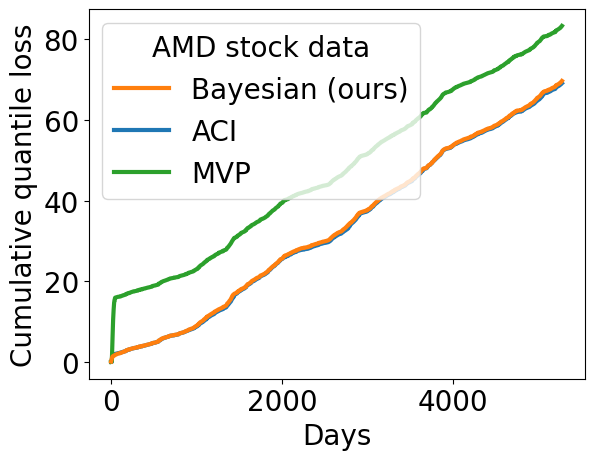

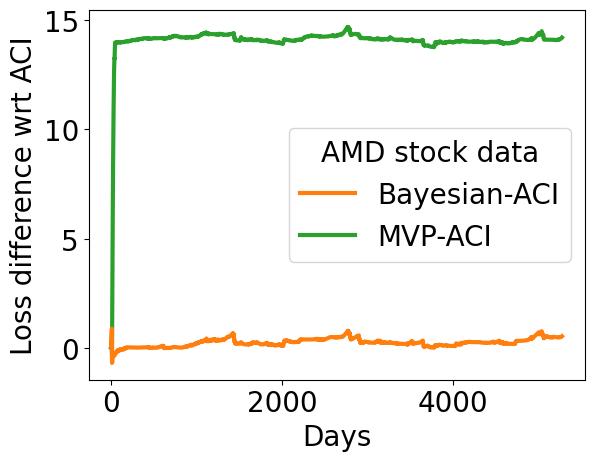

In [7]:
ACI_loss = np.zeros(T)
MVP_loss = np.zeros(T)
Bayesian_loss = np.zeros(T)

for t in range(T):
    ACI_loss[t] = utils.quantile_loss(ACI_thresholds[t], scores[t], queried_confidence)
    MVP_loss[t] = utils.quantile_loss(MVP_thresholds[t], scores[t], queried_confidence)
    Bayesian_loss[t] = utils.quantile_loss(Bayesian_thresholds[t], scores[t], queried_confidence)

ACI_total_loss = np.cumsum(ACI_loss)
MVP_total_loss = np.cumsum(MVP_loss)
Bayesian_total_loss = np.cumsum(Bayesian_loss)

plt.plot(Bayesian_total_loss, label='Bayesian (ours)', color='#ff7f0e', zorder=3)
plt.plot(ACI_total_loss, label='ACI', color='#1f77b4', zorder=1)
plt.plot(MVP_total_loss, label='MVP', color = '#2ca02c',zorder=2)
plt.legend(title=f'{dataset_name} stock data')
plt.xlabel('Days')
plt.ylabel('Cumulative quantile loss')
plt.savefig(f"Figures/stock_total_loss_{dataset_name}.pdf", bbox_inches='tight')
plt.show()

plt.plot(Bayesian_total_loss - ACI_total_loss, label='Bayesian-ACI', color='#ff7f0e', zorder=3)
plt.plot(MVP_total_loss - ACI_total_loss, label='MVP-ACI', color = '#2ca02c',zorder=2)
plt.legend(title=f'{dataset_name} stock data')
plt.xlabel('Days')
plt.ylabel('Loss difference wrt ACI')
plt.savefig(f"Figures/stock_loss_diff_{dataset_name}.pdf", bbox_inches='tight')
plt.show()